In [1]:
import pandas_datareader.data as web#从互联网上拿数据
import datetime
start = datetime.datetime(2000,1,1)
end = datetime.datetime(2022,3,19)
df = web.DataReader('GOOGL','stooq',start,end)#谷歌股票

In [15]:
df

,Open,High,Low,Close,Volume,label
Date,,,,,,
2004-08-19,50.000,52.030,47.980,50.170,44703800.0,50.755
2004-08-20,50.505,54.540,50.250,54.155,22857200.0,50.005
2004-08-23,55.375,56.740,54.525,54.700,18274400.0,50.790
2004-08-24,55.620,55.800,51.785,52.435,15262600.0,51.150
2004-08-25,52.480,54.000,51.940,53.000,9197800.0,51.155
...,...,...,...,...,...,...
2022-03-14,2605.000,2608.180,2505.500,2519.020,1940563.0,NaN
2022-03-15,2539.520,2597.090,2514.410,2583.960,1545976.0,NaN
2022-03-16,2614.660,2666.660,2574.690,2665.610,1778849.0,NaN


In [2]:
def Stock_Price_LSTM_Data_Precesing(df,mem_his_days,pre_days):
    df.dropna(inplace=True)#删除空值
    df.sort_index(inplace=True)#按时间从小到大排序

    df['label'] = df['Close'].shift(-pre_days)#加一个lable收盘价往上移10天

    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()#数据标准化(均值方差归一化https://www.cnblogs.com/volcao/p/9089716.html)
    sca_X = scaler.fit_transform(df.iloc[:,:-1])#去掉最后一列lable

   

    from collections import deque#引入队列(先进先出)
    deq = deque(maxlen = mem_his_days)

    X = [] #list
    for i in sca_X:
        deq.append(list(i))
        if len(deq)==mem_his_days:
            X.append(list(deq))

    X_lately = X[-pre_days:]#记录最后几条记录
    X = X[:-pre_days]


    y = df['label'][mem_his_days-1:-pre_days]


    import numpy as np
    X = np.array(X)
    y = np.array(y)
    
    return X,y,X_lately

In [4]:
pre_days = 10
# mem_days = [5,10,15]
# lstm_layers = [1,2,3]
# dense_layers = [1,2,3]
# units = [16,32]#神经元
mem_days = [5]
lstm_layers = [1]
dense_layers = [1]
units = [32]#神经元


from tensorflow.keras.callbacks import ModelCheckpoint#查找训练最佳的模型
for the_mem_days in mem_days:
    for the_lstm_layers in lstm_layers:
        for the_dense_layers in dense_layers:
            for the_units in units:
                filepath = './models/{val_mape:.2f}_{epoch:02d}_'+f'mem_{the_mem_days}_lstm_{the_lstm_layers}_dense_{the_dense_layers}_unit_{the_units}'
                checkpoint = ModelCheckpoint(
                    filepath = filepath,
                    save_weights_only=False,#保存模型权重（True），false是保存模型全部
                    monitor='val_mape',
                    mode = 'min',
                    save_best_only=True
                    
                )
                X,y,X_lately = Stock_Price_LSTM_Data_Precesing(df,the_mem_days,pre_days)
                from sklearn.model_selection import train_test_split
                X_train,X_test,y_train,y_test = train_test_split(X,y,shuffle=False,test_size=0.1)
                
                import tensorflow as tf
                from tensorflow.keras.models import Sequential#引入keras 序贯模型
                from tensorflow.keras.layers import LSTM,Dense,Dropout
                model = Sequential()
                model.add(LSTM(the_units,input_shape=X.shape[1:],activation='relu',return_sequences=True))#10个神经单元
                model.add(Dropout(0.1))#防止过拟合
                
                for i in range(the_lstm_layers):
                    model.add(LSTM(the_units,activation='relu',return_sequences=True))
                    model.add(Dropout(0.1))
                    
                model.add(LSTM(the_units,activation='relu'))
                model.add(Dropout(0.1))
                
                for i in range(the_dense_layers):
                    
                    model.add(Dense(the_units,activation='relu'))#全连接层
                    model.add(Dropout(0.1))

                model.add(Dense(1))#输出层



                model.compile(optimizer='adam',
                               loss='mse',  
                               metrics=['mape'])#优化器adam，损失函数平均方差,评价函数mape（平均误差率）

                model.fit(X_train,y_train,batch_size=32,epochs=50,validation_data=(X_test,y_test),callbacks=[checkpoint])



Epoch 1/50
119/125 [===========================>..] - ETA: 0s - loss: 245003.2344 - mape: 73.7186INFO:tensorflow:Assets written to: ./models\109.15_01_mem_5_lstm_1_dense_1_unit_32\assets


125/125 [==============================] - 7s 39ms/step - loss: 236548.7969 - mape: 71.9019 - val_loss: 11777194.0000 - val_mape: 109.1479
Epoch 2/50
124/125 [============================>.] - ETA: 0s - loss: 20227.9727 - mape: 26.9531INFO:tensorflow:Assets written to: ./models\54.03_02_mem_5_lstm_1_dense_1_unit_32\assets


INFO:tensorflow:Assets written to: ./models\54.03_02_mem_5_lstm_1_dense_1_unit_32\assets


125/125 [==============================] - 4s 35ms/step - loss: 20224.8594 - mape: 26.9448 - val_loss: 3217828.7500 - val_mape: 54.0309
Epoch 3/50
121/125 [============================>.] - ETA: 0s - loss: 15364.9111 - mape: 24.0329INFO:tensorflow:Assets written to: ./models\43.71_03_mem_5_lstm_1_dense_1_unit_32\assets


INFO:tensorflow:Assets written to: ./models\43.71_03_mem_5_lstm_1_dense_1_unit_32\assets


125/125 [==============================] - 4s 33ms/step - loss: 15301.6816 - mape: 24.0240 - val_loss: 2082003.8750 - val_mape: 43.7118
Epoch 4/50
123/125 [============================>.] - ETA: 0s - loss: 12753.7295 - mape: 21.7737INFO:tensorflow:Assets written to: ./models\34.48_04_mem_5_lstm_1_dense_1_unit_32\assets


INFO:tensorflow:Assets written to: ./models\34.48_04_mem_5_lstm_1_dense_1_unit_32\assets


125/125 [==============================] - 4s 35ms/step - loss: 12770.9395 - mape: 21.7716 - val_loss: 1326604.2500 - val_mape: 34.4790
Epoch 5/50
119/125 [===========================>..] - ETA: 0s - loss: 11478.0850 - mape: 18.1787INFO:tensorflow:Assets written to: ./models\24.58_05_mem_5_lstm_1_dense_1_unit_32\assets


INFO:tensorflow:Assets written to: ./models\24.58_05_mem_5_lstm_1_dense_1_unit_32\assets


125/125 [==============================] - 4s 32ms/step - loss: 11460.0547 - mape: 17.9679 - val_loss: 658311.3750 - val_mape: 24.5784
Epoch 6/50
122/125 [============================>.] - ETA: 0s - loss: 9387.9111 - mape: 15.7687INFO:tensorflow:Assets written to: ./models\20.73_06_mem_5_lstm_1_dense_1_unit_32\assets


INFO:tensorflow:Assets written to: ./models\20.73_06_mem_5_lstm_1_dense_1_unit_32\assets


125/125 [==============================] - 4s 34ms/step - loss: 9346.5537 - mape: 15.8168 - val_loss: 478480.3750 - val_mape: 20.7270
Epoch 7/50
125/125 [==============================] - 1s 7ms/step - loss: 8636.5029 - mape: 14.1795 - val_loss: 584205.3750 - val_mape: 22.5187
Epoch 8/50
125/125 [==============================] - ETA: 0s - loss: 8143.6519 - mape: 13.5395INFO:tensorflow:Assets written to: ./models\16.82_08_mem_5_lstm_1_dense_1_unit_32\assets


INFO:tensorflow:Assets written to: ./models\16.82_08_mem_5_lstm_1_dense_1_unit_32\assets


125/125 [==============================] - 4s 33ms/step - loss: 8143.6519 - mape: 13.5395 - val_loss: 279930.3750 - val_mape: 16.8212
Epoch 9/50
124/125 [============================>.] - ETA: 0s - loss: 8309.8271 - mape: 13.6772INFO:tensorflow:Assets written to: ./models\14.26_09_mem_5_lstm_1_dense_1_unit_32\assets


INFO:tensorflow:Assets written to: ./models\14.26_09_mem_5_lstm_1_dense_1_unit_32\assets


125/125 [==============================] - 4s 35ms/step - loss: 8306.8994 - mape: 13.6782 - val_loss: 168009.3750 - val_mape: 14.2584
Epoch 10/50
125/125 [==============================] - 1s 7ms/step - loss: 7284.2344 - mape: 13.0547 - val_loss: 242020.1094 - val_mape: 14.9266
Epoch 11/50
118/125 [===========================>..] - ETA: 0s - loss: 7705.9102 - mape: 13.0672INFO:tensorflow:Assets written to: ./models\14.04_11_mem_5_lstm_1_dense_1_unit_32\assets


INFO:tensorflow:Assets written to: ./models\14.04_11_mem_5_lstm_1_dense_1_unit_32\assets


125/125 [==============================] - 4s 34ms/step - loss: 7666.7783 - mape: 13.0076 - val_loss: 220142.7031 - val_mape: 14.0430
Epoch 12/50
125/125 [==============================] - 1s 7ms/step - loss: 7991.0220 - mape: 13.1723 - val_loss: 269661.1250 - val_mape: 15.3082
Epoch 13/50
123/125 [============================>.] - ETA: 0s - loss: 7681.5859 - mape: 13.1723INFO:tensorflow:Assets written to: ./models\11.76_13_mem_5_lstm_1_dense_1_unit_32\assets


INFO:tensorflow:Assets written to: ./models\11.76_13_mem_5_lstm_1_dense_1_unit_32\assets


125/125 [==============================] - 4s 36ms/step - loss: 7684.5015 - mape: 13.1872 - val_loss: 145848.0938 - val_mape: 11.7640
Epoch 14/50
122/125 [============================>.] - ETA: 0s - loss: 7994.3979 - mape: 12.8491INFO:tensorflow:Assets written to: ./models\11.18_14_mem_5_lstm_1_dense_1_unit_32\assets


INFO:tensorflow:Assets written to: ./models\11.18_14_mem_5_lstm_1_dense_1_unit_32\assets


125/125 [==============================] - 5s 36ms/step - loss: 7993.5073 - mape: 12.8258 - val_loss: 131245.7969 - val_mape: 11.1774
Epoch 15/50
123/125 [============================>.] - ETA: 0s - loss: 7718.6494 - mape: 12.6806INFO:tensorflow:Assets written to: ./models\9.18_15_mem_5_lstm_1_dense_1_unit_32\assets


INFO:tensorflow:Assets written to: ./models\9.18_15_mem_5_lstm_1_dense_1_unit_32\assets


125/125 [==============================] - 4s 35ms/step - loss: 7683.1304 - mape: 12.6552 - val_loss: 69302.3516 - val_mape: 9.1785
Epoch 16/50
125/125 [==============================] - ETA: 0s - loss: 6794.8853 - mape: 12.5420INFO:tensorflow:Assets written to: ./models\8.22_16_mem_5_lstm_1_dense_1_unit_32\assets


INFO:tensorflow:Assets written to: ./models\8.22_16_mem_5_lstm_1_dense_1_unit_32\assets


125/125 [==============================] - 5s 38ms/step - loss: 6794.8853 - mape: 12.5420 - val_loss: 51473.5703 - val_mape: 8.2224
Epoch 17/50
118/125 [===========================>..] - ETA: 0s - loss: 6692.3691 - mape: 12.4754INFO:tensorflow:Assets written to: ./models\8.16_17_mem_5_lstm_1_dense_1_unit_32\assets


INFO:tensorflow:Assets written to: ./models\8.16_17_mem_5_lstm_1_dense_1_unit_32\assets


125/125 [==============================] - 4s 34ms/step - loss: 6675.2061 - mape: 12.4600 - val_loss: 53170.3711 - val_mape: 8.1628
Epoch 18/50
125/125 [==============================] - 1s 7ms/step - loss: 7176.9795 - mape: 12.3209 - val_loss: 63834.9102 - val_mape: 11.1107
Epoch 19/50
121/125 [============================>.] - ETA: 0s - loss: 7902.4580 - mape: 12.6937INFO:tensorflow:Assets written to: ./models\7.85_19_mem_5_lstm_1_dense_1_unit_32\assets


INFO:tensorflow:Assets written to: ./models\7.85_19_mem_5_lstm_1_dense_1_unit_32\assets


125/125 [==============================] - 4s 35ms/step - loss: 7822.7349 - mape: 12.6585 - val_loss: 55933.2227 - val_mape: 7.8523
Epoch 20/50
125/125 [==============================] - 1s 7ms/step - loss: 6899.8594 - mape: 12.0915 - val_loss: 84132.8906 - val_mape: 12.8118
Epoch 21/50
125/125 [==============================] - 1s 6ms/step - loss: 7297.2246 - mape: 12.4380 - val_loss: 52478.0391 - val_mape: 9.8068
Epoch 22/50
125/125 [==============================] - 1s 7ms/step - loss: 6347.9468 - mape: 12.0850 - val_loss: 55796.7227 - val_mape: 10.1583
Epoch 23/50
125/125 [==============================] - 1s 6ms/step - loss: 6283.1050 - mape: 11.9467 - val_loss: 41252.4023 - val_mape: 8.5281
Epoch 24/50
121/125 [============================>.] - ETA: 0s - loss: 6430.0234 - mape: 11.8177INFO:tensorflow:Assets written to: ./models\6.19_24_mem_5_lstm_1_dense_1_unit_32\assets


INFO:tensorflow:Assets written to: ./models\6.19_24_mem_5_lstm_1_dense_1_unit_32\assets


125/125 [==============================] - 4s 33ms/step - loss: 6492.6216 - mape: 11.8480 - val_loss: 26453.1172 - val_mape: 6.1914
Epoch 25/50
125/125 [==============================] - 1s 7ms/step - loss: 6834.2686 - mape: 12.4316 - val_loss: 101031.6172 - val_mape: 13.8890
Epoch 26/50
125/125 [==============================] - 1s 7ms/step - loss: 6535.0283 - mape: 11.7186 - val_loss: 109477.2031 - val_mape: 14.4216
Epoch 27/50
125/125 [==============================] - 1s 6ms/step - loss: 6355.1138 - mape: 11.6917 - val_loss: 154082.9375 - val_mape: 17.1131
Epoch 28/50
125/125 [==============================] - 1s 7ms/step - loss: 6187.5933 - mape: 11.9478 - val_loss: 33018.8945 - val_mape: 7.2941
Epoch 29/50
125/125 [==============================] - 1s 7ms/step - loss: 6439.0122 - mape: 11.8777 - val_loss: 117650.7891 - val_mape: 14.6143
Epoch 30/50
117/125 [===========================>..] - ETA: 0s - loss: 5774.7520 - mape: 11.5826INFO:tensorflow:Assets written to: ./models\5.27_

INFO:tensorflow:Assets written to: ./models\5.27_30_mem_5_lstm_1_dense_1_unit_32\assets


125/125 [==============================] - 4s 34ms/step - loss: 5753.3115 - mape: 11.6526 - val_loss: 20132.7090 - val_mape: 5.2666
Epoch 31/50
125/125 [==============================] - 1s 7ms/step - loss: 5764.0107 - mape: 11.3392 - val_loss: 58852.2773 - val_mape: 9.9363
Epoch 32/50
125/125 [==============================] - 1s 7ms/step - loss: 5957.1895 - mape: 11.1929 - val_loss: 123374.5938 - val_mape: 14.7503
Epoch 33/50
125/125 [==============================] - 1s 7ms/step - loss: 5467.5381 - mape: 11.2100 - val_loss: 97208.9219 - val_mape: 13.1277
Epoch 34/50
125/125 [==============================] - 1s 7ms/step - loss: 5958.4180 - mape: 11.4024 - val_loss: 175388.5625 - val_mape: 17.7847
Epoch 35/50
125/125 [==============================] - 1s 7ms/step - loss: 6518.1465 - mape: 11.4900 - val_loss: 110777.4375 - val_mape: 13.9273
Epoch 36/50
125/125 [==============================] - 1s 7ms/step - loss: 5728.8242 - mape: 10.7889 - val_loss: 254862.0469 - val_mape: 21.4506
E

In [6]:
from tensorflow.keras.models import load_model
best_model = load_model('./models/5.27_30_mem_5_lstm_1_dense_1_unit_32')

In [7]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 32)             4864      
                                                                 
 dropout (Dropout)           (None, 5, 32)             0         
                                                                 
 lstm_1 (LSTM)               (None, 5, 32)             8320      
                                                                 
 dropout_1 (Dropout)         (None, 5, 32)             0         
                                                                 
 lstm_2 (LSTM)               (None, 32)                8320      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 32)                1

In [13]:
best_model.evaluate(X_test,y_test)
pre = best_model.predict(X_test)

14/14 [==============================] - 0s 3ms/step - loss: 20132.7090 - mape: 5.2666


In [9]:
model.evaluate(X_test,y_test)

14/14 [==============================] - 0s 2ms/step - loss: 218645.2656 - mape: 18.6307


[218645.265625, 18.630733489990234]

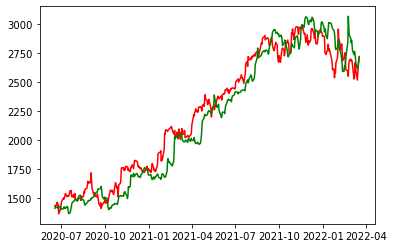

In [14]:
import matplotlib.pyplot as plt
df_time = df.index[-len(y_test):]
plt.plot(df_time,y_test,color='red',label='price')
plt.plot(df_time,pre,color='green',label='predict')
plt.show()
